# Driver Drowsiness Model: CS 539

## Step 1: Preprocess Data
As an initial step we will follow the Kaggle notebook to preprocess the data. Once we start selecting models and fine tuning, we will go back to see if we need to update the sizes of our training and testing datasets split.

In [1]:
!pip install torchsummary

In [2]:
import os
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import transforms
from torchvision import  transforms, models
from torchsummary import summary
from PIL import Image 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
!pip install kagglehub
!pip install kaggle

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

print("Path to dataset files:", path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.58G/2.58G [03:12<00:00, 14.4MB/s]

Extracting files...


Path to dataset files: /Users/sanvi/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1


In [12]:
import os
import shutil

# src_path = "1/Driver Drowsiness Dataset (DDD)" 
# dest_path = "Driver Drowsiness Dataset (DDD)" 

# shutil.move(src_path, dest_path)
# shutil.rmtree("1")

main_path = os.getcwd()

drowsy_paths = [os.path.join(main_path, 'Driver Drowsiness Dataset (DDD)', 'Drowsy', p) 
                for p in os.listdir(os.path.join(main_path, 'Driver Drowsiness Dataset (DDD)', 'Drowsy'))]

non_drowsy_paths = [os.path.join(main_path, 'Driver Drowsiness Dataset (DDD)', 'Non Drowsy', p) 
                    for p in os.listdir(os.path.join(main_path, 'Driver Drowsiness Dataset (DDD)', 'Non Drowsy'))]

print("Drowsy paths:", drowsy_paths[:5]) 
print("Non Drowsy paths:", non_drowsy_paths[:5]) 

all_dirs = drowsy_paths +  non_drowsy_paths

random.shuffle(all_dirs)

total_size = len(all_dirs)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  

# Split the data
train_paths = all_dirs[:train_size]
val_paths = all_dirs[train_size:train_size + val_size]
test_paths = all_dirs[train_size + val_size:]

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

len_all_dirs = len(all_dirs)
len_train_paths = len(train_paths)
len_val_paths = len(val_paths)
len_test_paths = len(test_paths)

print(f"Total images: {len_all_dirs}")
print(f"Training set: {len_train_paths} images")
print(f"Validation set: {len_val_paths} images")
print(f"Test set: {len_test_paths} images")

Drowsy paths: ['/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Drowsy/A0644.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Drowsy/Y0288.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Drowsy/E0260.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Drowsy/Y1196.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Drowsy/X1385.png']
Non Drowsy paths: ['/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0644.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0288.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0260.png', '/Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/y1196.png', '/Use

In [13]:
def extract_class_name(p):
    return p.split('/')[-2]

path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/i0294.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/q0225.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0747.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/u0436.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/n0493.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Drowsy/J0103.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/x0442.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0806.png
path:  /Users/sanvi/Desktop/cs539/project/driver-drowsiness/Driver Drowsiness Dataset (DDD)/Non Drow

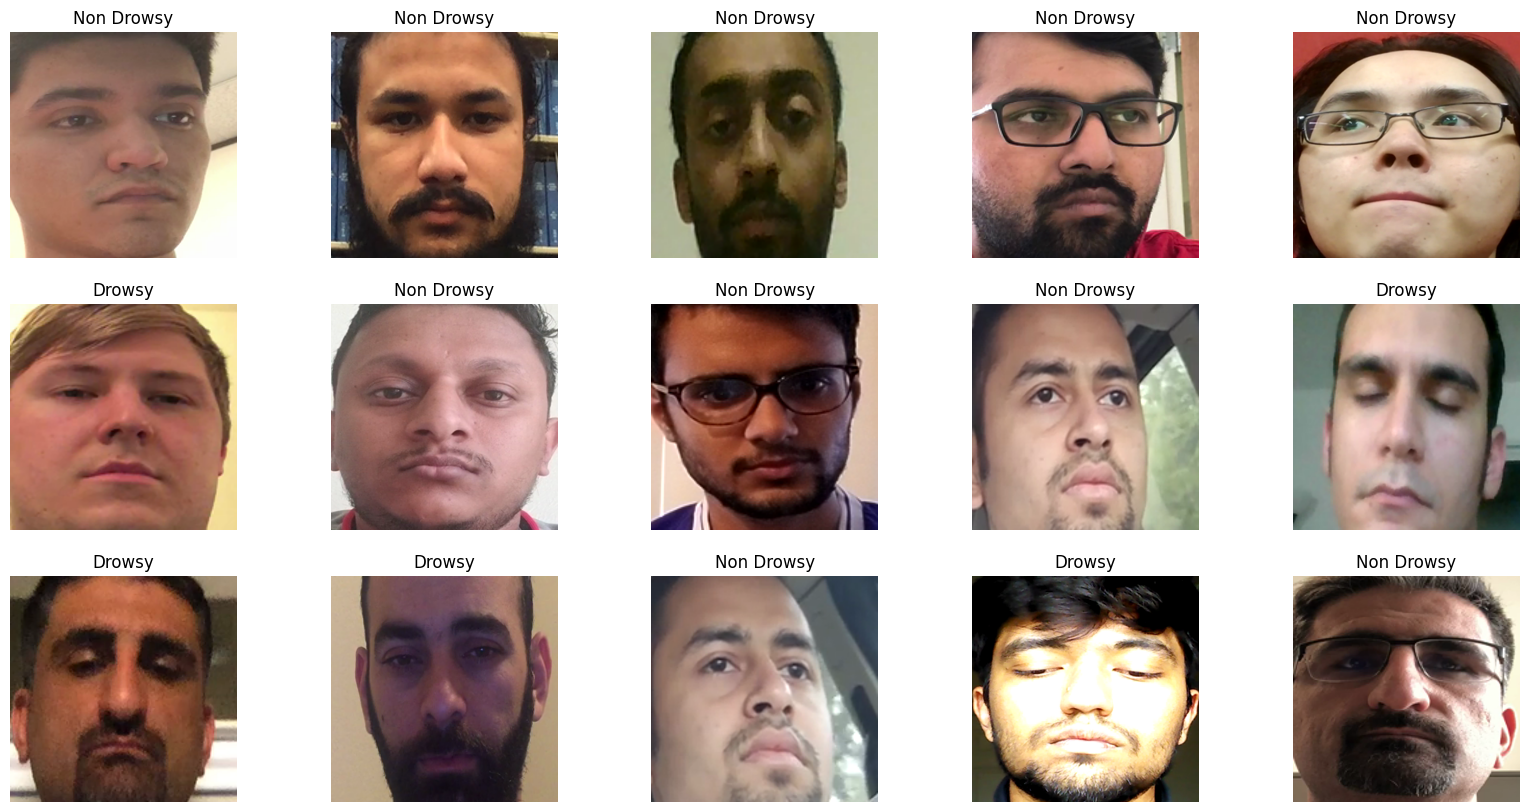

In [14]:
def show_images_with_labels(paths, num_images=15):
    plt.figure(figsize=(20, 10))
    for i, path in enumerate(paths[:num_images]):
        print("path: ", path)
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images_with_labels(train_paths, num_images=15)